<a href="https://colab.research.google.com/github/chivy-debug/Detect_URL_Phishing_ML-DL/blob/main/Detect_URL_Phishing_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import các thư viện
import pandas as pd
import re
from joblib import dump, load
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

# Tải dataset
df = pd.read_csv("/content/dataset_link_phishing.csv")

In [ ]:
# Hàm rút trích 64 đặc trưng từ URL
def extract_features(url):
    features = []

    if isinstance(url, str):
        # Phân tích URL
        parsed_url = urlparse(url)
        hostname = parsed_url.hostname if parsed_url.hostname else ''

        # 1. Độ dài của URL
        features.append(len(url))

        # 2. Độ dài của hostname
        features.append(len(hostname))

        # 3. Địa chỉ IP trong URL
        features.append(1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0)

        # 4-18. Tổng số ký tự đặc biệt trong URL (từ . đến $)
        special_chars = ['.', '-', '@', '?', '&', '=', '_', '~', '%',
                         '/', '*', ':', ',', ';', '$']
        for char in special_chars:
            features.append(len(re.findall(re.escape(char), url)))

        # 19. Số lần xuất hiện 'www'
        features.append(url.count('www'))

        # 20. Số lần xuất hiện '.com'
        features.append(url.count('.com'))

        # 21. HTTPS trong URL
        features.append(1 if 'https' in url else 0)

        # 22. Tỉ lệ ký tự số trong URL
        digits = sum(c.isdigit() for c in url)
        features.append(digits / len(url) if len(url) > 0 else 0)

        # 23. Tỉ lệ ký tự số trong hostname
        digits_in_host = sum(c.isdigit() for c in hostname)
        features.append(digits_in_host / len(hostname) if len(hostname) > 0 else 0)

        # 24. Số lượng subdomain
        subdomain_count = len(hostname.split('.')) - 2 if hostname else 0
        features.append(subdomain_count)

        # 25. Độ dài từ ngắn nhất trong hostname
        words_in_host = re.split(r'[\.-]', hostname)
        shortest_word_host = min([len(word) for word in words_in_host if word]) if words_in_host else 0
        features.append(shortest_word_host)

        # 26. Độ dài từ dài nhất trong hostname
        longest_word_host = max([len(word) for word in words_in_host if word]) if words_in_host else 0
        features.append(longest_word_host)

        # 27. Độ dài từ trung bình trong hostname
        avg_word_host = sum([len(word) for word in words_in_host]) / len(words_in_host) if words_in_host else 0
        features.append(avg_word_host)

        # 28. URL sử dụng tên miền rút gọn
        shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 'is.gd']
        features.append(1 if any(shortener in url for shortener in shorteners) else 0)

        # 29. URL chứa địa chỉ email
        features.append(1 if re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', url) else 0)

        # 30. Tỉ lệ ký tự chữ cái trong URL
        letters = sum(c.isalpha() for c in url)
        features.append(letters / len(url) if len(url) > 0 else 0)

        # 31. Số lượng từ trong URL
        words_in_url = len(re.findall(r'\w+', url))
        features.append(words_in_url)

        # 32. Độ dài của phần path
        path = parsed_url.path
        features.append(len(path))

        # 33. Số lượng ký tự trong path
        features.append(len(re.findall(r'\w+', path)))

        # 34. URL chứa domain đáng ngờ
        suspicious_domains = ['login', 'secure', 'account', 'verify', 'update',
                              'authentication', 'confirmation', 'validation',
                              'security-check', 'identity-verify']
        features.append(1 if any(domain in url for domain in suspicious_domains) else 0)

        # 35. Tỉ lệ ký tự số trong path
        digits_in_path = sum(c.isdigit() for c in path)
        features.append(digits_in_path / len(path) if len(path) > 0 else 0)

        # 36. Số lượng dấu '/' trong path
        features.append(path.count('/'))

        # 37. URL sử dụng TLD không phổ biến
        uncommon_tlds = ['xyz', 'top', 'click', 'online', 'icu', 'info',
                         'tk', 'ga', 'cf', 'ml', 'gq', 'loan', 'win',
                         'shop', 'site', 'us', 'pw']
        tld = hostname.split('.')[-1] if hostname else ''
        features.append(1 if tld in uncommon_tlds else 0)

        # 38. Số lượng tham số trong query
        query = parsed_url.query
        features.append(len(query.split('&')) if query else 0)

        # 39. Độ dài của phần query
        features.append(len(query) if query else 0)

        # 40. Query có chứa ký tự đặc biệt đáng ngờ không
        suspicious_query_chars = ['%20', '%22', '%27', '%3C', '%3E']
        features.append(1 if any(char in query for char in suspicious_query_chars) else 0)

        # 41. Tên miền chứa thương hiệu phổ biến
        trusted_domains = ['facebook.com', 'google.com', 'paypal.com', 'amazon.com',
                           'microsoft.com', 'apple.com', 'linkedin.com', 'twitter.com',
                           'netflix.com', 'bank.com', 'creditcard.com']
        features.append(1 if any(
            brand in hostname and hostname not in trusted_domains
            for brand in trusted_domains
        ) else 0)

        # 42. Tổng độ dài các subdomain
        subdomains = hostname.split('.')[:-2] if hostname else []
        features.append(sum(len(sub) for sub in subdomains))

        # 43. Subdomain đáng ngờ
        suspicious_subdomains = ['login', 'secure', 'account', 'auth', 'verify',
                                 'security', 'validation', 'confirm', 'admin']
        features.append(1 if any(sub in subdomains for sub in suspicious_subdomains) else 0)

        # 44. Tỉ lệ dấu '/' trong URL
        features.append(url.count('/') / len(url) if len(url) > 0 else 0)

        # 45. Path chứa từ khóa đáng ngờ
        suspicious_path_keywords = ['reset', 'confirm', 'admin', 'auth',
                                    'login', 'account', 'password',
                                    'recover', 'verification', 'update-credentials']
        features.append(1 if any(keyword in path for keyword in suspicious_path_keywords) else 0)

        # 46. Hostname chứa ký tự đặc biệt
        features.append(1 if any(char in hostname for char in ['_', '~', '$']) else 0)

        # 47. Tỉ lệ từ ngắn bất thường trong hostname
        invalid_words_in_host = [word for word in words_in_host if len(word) < 3]
        features.append(len(invalid_words_in_host) / len(words_in_host) if words_in_host else 0)

        # 48. Số lượng dấu '.' trong hostname
        features.append(hostname.count('.'))

        # 49. HTTPS trong hostname nhưng URL không bắt đầu bằng HTTPS
        features.append(1 if 'https' in hostname and not url.startswith('https') else 0)

        # 50. Độ dài của TLD
        features.append(len(tld))

        # 51. Query kết thúc bằng ký tự không hợp lệ
        features.append(1 if re.search(r'=[&]*$', query) else 0)

        # 52. Dấu hiệu chuyển hướng đáng ngờ
        features.append(1 if 'http://' in query or 'http://' in path else 0)

        # 53. Kiểm tra URL có chứa từ khóa không tin cậy trong phần path
        untrusted_path_keywords = ['fake', 'fraud', 'phishing', 'malware']
        features.append(1 if any(keyword in path for keyword in untrusted_path_keywords) else 0)

        # 54. Số lượng ký tự hoa trong URL (Kiểm tra xem URL có sử dụng nhiều chữ cái in hoa không)
        uppercase_count = sum(1 for c in url if c.isupper())
        features.append(uppercase_count)

        # 55. Tỉ lệ ký tự in hoa so với tổng ký tự trong URL
        features.append(uppercase_count / len(url) if len(url) > 0 else 0)

        # 56. Độ dài phần fragment (phần sau dấu '#')
        fragment = parsed_url.fragment
        features.append(len(fragment) if fragment else 0)

        # 57. URL có chứa từ khóa đáng ngờ trong fragment không
        suspicious_fragment_keywords = ['reset', 'confirm', 'secure', 'auth']
        features.append(1 if any(keyword in fragment for keyword in suspicious_fragment_keywords) else 0)

        # 58. Mã hóa đáng ngờ
        suspicious_encodings = ['%00', '%3A', '%2F', '%2E', '%5C']
        features.append(1 if any(encoding in url for encoding in suspicious_encodings) else 0)

        # 59. Ký tự lặp lại bất thường
        features.append(1 if re.search(r'\.\.\.\.|----', url) else 0)

        # 60. Tên miền quốc gia không phổ biến
        uncommon_ccTLDs = ['.tk', '.ga', '.cf', '.ml', '.gq']
        features.append(1 if any(tld.endswith(ccTLD) for ccTLD in uncommon_ccTLDs) else 0)

        # 61. Ký tự đặc biệt bất thường trong hostname
        special_chars_in_host = ['%', '$', '^', '&', '*', '(', ')', '=', '+', '#']
        features.append(sum(hostname.count(char) for char in special_chars_in_host))

        # 62. Từ khóa bảo mật trong bối cảnh đáng ngờ
        suspicious_security_keywords = ['secure', 'ssl', 'certified']
        features.append(1 if any(
            keyword in hostname and hostname not in trusted_domains
            for keyword in suspicious_security_keywords
        ) else 0)

        # 63. Độ dài URL bất thường
        features.append(1 if len(url) < 15 or len(url) > 200 else 0)

        # 64. Chuỗi giống mã trong hostname
        random_string_pattern = r'[a-zA-Z0-9]{10,}'
        features.append(1 if re.search(random_string_pattern, hostname) else 0)

    else:
        features = [0] * 64  # Nếu URL không hợp lệ, điền toàn bộ bằng 0

    return features


# Trích xuất các đặc trưng từ URL
df['features'] = df['url'].apply(extract_features)

# Chuẩn bị dữ liệu đầu vào
X = pd.DataFrame(df['features'].tolist())  # Chuyển đổi danh sách đặc trưng thành DataFrame
y = df['label']  # Nhãn 1 (phishing), 0 (legit)

# Chia dữ liệu thành tập huấn luyện và kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Train Accuracy: 0.992
Test Accuracy: 0.962
Accuracy: 0.962
Precision: 0.955
Recall: 0.968
F1-Score: 0.962

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.956     0.962      1976
           1      0.955     0.968     0.962      1911

    accuracy                          0.962      3887
   macro avg      0.962     0.962     0.962      3887
weighted avg      0.962     0.962     0.962      3887



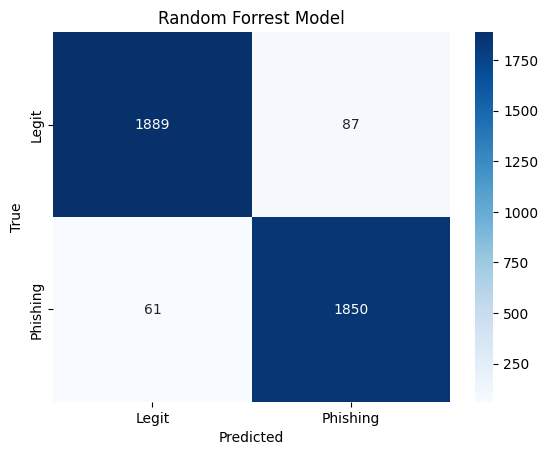

In [ ]:
# Mô hình Random Forrest
from sklearn.ensemble import RandomForestClassifier

# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=450, random_state=0)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Kết quả training
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# Tính Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='binary')  # average='binary' cho bài toán nhị phân
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

# Hoặc in đầy đủ báo cáo
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.title('Random Forrest Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Train Accuracy: 0.990
Test Accuracy: 0.962
Accuracy: 0.962
Precision: 0.956
Recall: 0.967
F1-Score: 0.961

Classification Report:
              precision    recall  f1-score   support

           0      0.967     0.957     0.962      1976
           1      0.956     0.967     0.961      1911

    accuracy                          0.962      3887
   macro avg      0.962     0.962     0.962      3887
weighted avg      0.962     0.962     0.962      3887



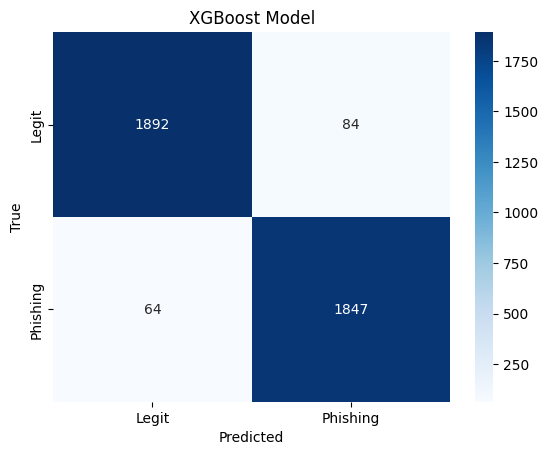

In [ ]:
# Mô hình XGBoost
import xgboost as xgb

# Huấn luyện mô hình XGBoost
model = xgb.XGBClassifier(n_estimators=360, random_state=0)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Kết quả training
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# Tính Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='binary')  # average='binary' cho bài toán nhị phân
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

# Hoặc in đầy đủ báo cáo
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.title('XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Train Accuracy: 0.931
Test Accuracy: 0.910
Accuracy: 0.910
Precision: 0.913
Recall: 0.903
F1-Score: 0.908

Classification Report:
              precision    recall  f1-score   support

           0      0.907     0.917     0.912      1976
           1      0.913     0.903     0.908      1911

    accuracy                          0.910      3887
   macro avg      0.910     0.910     0.910      3887
weighted avg      0.910     0.910     0.910      3887



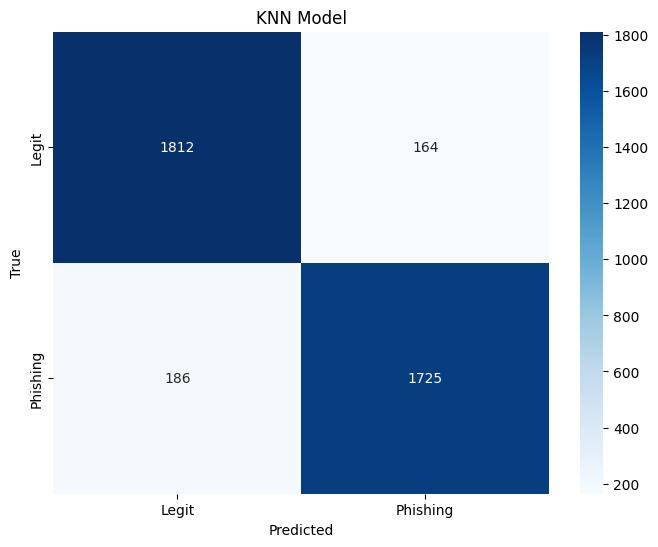

In [ ]:
# Mô hình KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu (quan trọng cho KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Khởi tạo và huấn luyện mô hình KNN
k = 5  # Số lượng neighbors
model = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto')
model.fit(X_train_scaled, y_train)

# Dự đoán
y_pred = model.predict(X_test_scaled)

# Kết quả training
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# Tính Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

# In đầy đủ báo cáo
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.title('KNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Train Accuracy: 0.896
Test Accuracy: 0.882

Accuracy: 0.882
Precision: 0.879
Recall: 0.881
F1-Score: 0.880

Classification Report:
              precision    recall  f1-score   support

           0      0.885     0.883     0.884      1976
           1      0.879     0.881     0.880      1911

    accuracy                          0.882      3887
   macro avg      0.882     0.882     0.882      3887
weighted avg      0.882     0.882     0.882      3887



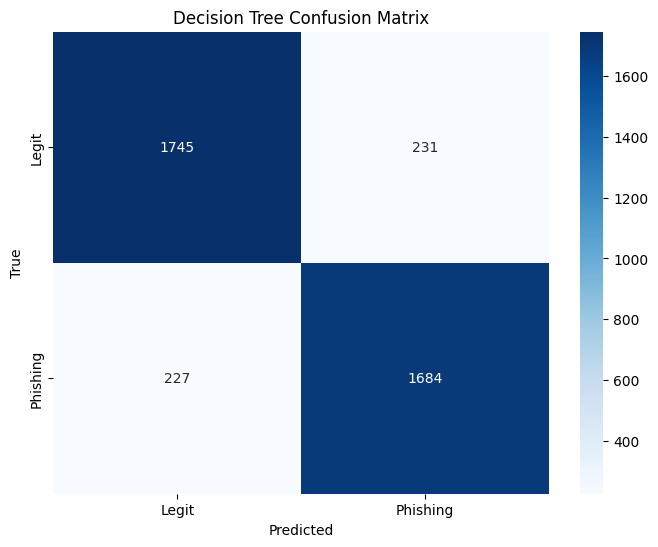

In [ ]:
# Mô hình Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo và huấn luyện mô hình Decision Tree
dt_model = DecisionTreeClassifier(random_state=0, max_depth=10)  # max_depth để tránh overfitting
dt_model.fit(X_train, y_train)

# Dự đoán
y_pred = dt_model.predict(X_test)

# Đánh giá mô hình
train_accuracy = dt_model.score(X_train, y_train)
test_accuracy = dt_model.score(X_test, y_test)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

# Các metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'\nAccuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')
plt.show()

Train Accuracy: 0.844
Test Accuracy: 0.853
Accuracy: 0.853
Precision: 0.853
Recall: 0.848
F1-Score: 0.850

Classification Report:
              precision    recall  f1-score   support

           0      0.854     0.858     0.856      1976
           1      0.853     0.848     0.850      1911

    accuracy                          0.853      3887
   macro avg      0.853     0.853     0.853      3887
weighted avg      0.853     0.853     0.853      3887



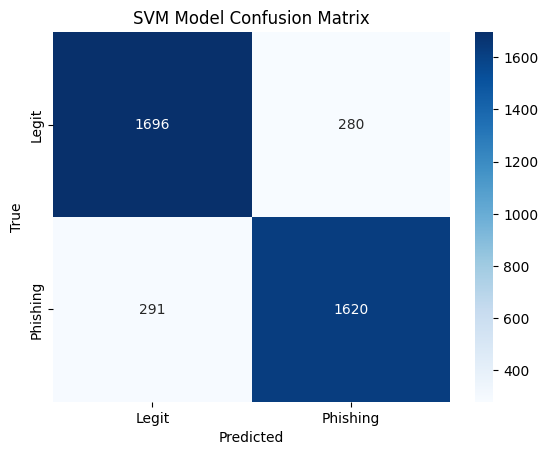

In [ ]:
# Mô hình SVM
from sklearn.svm import SVC

# Huấn luyện mô hình SVM
model = SVC(kernel='linear', random_state=0)  # Bạn có thể thay đổi kernel (linear, rbf, poly) tùy ý
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá mô hình
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# Tính Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='binary')  # average='binary' cho bài toán nhị phân
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

# Hoặc in đầy đủ báo cáo
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
# Hiển thị confusion matrix dưới dạng heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Model Confusion Matrix')
plt.show()

Accuracy: 0.963
Precision: 0.955
Recall: 0.970
F1-Score: 0.963

Classification Report:
              precision    recall  f1-score   support

           0      0.971     0.956     0.963      1976
           1      0.955     0.970     0.963      1911

    accuracy                          0.963      3887
   macro avg      0.963     0.963     0.963      3887
weighted avg      0.963     0.963     0.963      3887



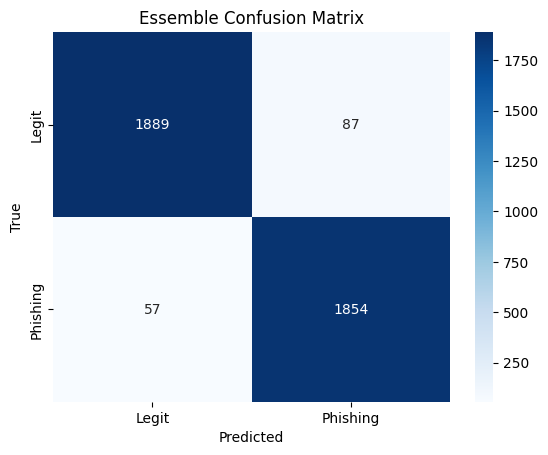

In [ ]:
# Mô hình Essemble kết hợp Random Forrest và XGBoost
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Base models
rf_model = RandomForestClassifier(n_estimators=450, random_state=0)
xgb_model = XGBClassifier(n_estimators=360, random_state=0)

# Huấn luyện các base models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Dự đoán từ các base models
rf_preds_train = rf_model.predict_proba(X_train)[:, 1]
xgb_preds_train = xgb_model.predict_proba(X_train)[:, 1]
rf_preds_test = rf_model.predict_proba(X_test)[:, 1]
xgb_preds_test = xgb_model.predict_proba(X_test)[:, 1]

# Kết hợp các dự đoán thành đầu vào cho meta-model
stacked_train = np.column_stack((rf_preds_train, xgb_preds_train))
stacked_test = np.column_stack((rf_preds_test, xgb_preds_test))

# Meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)

# Dự đoán cuối cùng
final_preds = meta_model.predict(stacked_test)

# Đánh giá hiệu suất
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, final_preds, digits=3))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Essemble Confusion Matrix')
plt.show()

In [ ]:
# Lưu mô hình thành module .pkl
'''
# Lưu mô hình vào file pkl
model_filename = 'phishing_model.pkl'
dump(model, model_filename)
print(f"Mô hình đã được lưu vào {model_filename}")
'''